# Visualization of Scan Benchmark Results

Should the plots be saved as PDF?

In [1]:
save_plots = True

### Define some CSV related constants

In [2]:
TYPE_STRING = 1
TYPE_INT = 0
OPERATION_EQUALS = 0
OPERATION_EQUALS_BITSET = 1
OPERATION_EQUALS_DICT = 2
OPERATION_EQUALS_DICT_BITSET = 3
OPERATION_EQUALS_INDEX = 4
OPERATION_EQUALS_BTREE = 5

### Define functions for scatter plots

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def get_df(filename):
    df = pd.read_csv(filename)
    return df

def get_dataframes_per_operation(dataframe):
    df_raw = dataframe[dataframe.operation == OPERATION_EQUALS]
    df_dict = dataframe[dataframe.operation == OPERATION_EQUALS_DICT]
    df_index = dataframe[dataframe.operation == OPERATION_EQUALS_INDEX]
    df_raw_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_BITSET]
    df_dict_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_DICT_BITSET]
    df_btree = dataframe[dataframe.operation == OPERATION_EQUALS_BTREE]
    
    return df_raw, df_dict, df_index, df_raw_bitset, df_dict_bitset, df_btree


def get_mean_durations_per_selectivity(dataframe):
    mean_durations = []
    selectivities = []
    for value in dataframe['selectivity'].unique():
        values = dataframe[dataframe.selectivity == value]
        means = values.mean()
        mean_durations.append(means['duration_microseconds'])
        selectivities.append(means['selectivity'])
    return mean_durations


def get_mean_durations_by_operation_and_selectivity(df1, df2, df3, df4, df5, df6):
    mean_durations_1 = get_mean_durations_per_selectivity(df1)
    mean_durations_2 = get_mean_durations_per_selectivity(df2)
    mean_durations_3 = get_mean_durations_per_selectivity(df3)
    mean_durations_4 = get_mean_durations_per_selectivity(df4)
    mean_durations_5 = get_mean_durations_per_selectivity(df5)
    mean_durations_6 = get_mean_durations_per_selectivity(df6)
    
    return mean_durations_1, mean_durations_2, mean_durations_3, mean_durations_4, mean_durations_5, mean_durations_6


def get_comparing_scatter_plot(x, ys, labels, axes, title):
    # show duration in milliseconds
    y = [[ i * 0.001 for i in y ] for y in ys ]
        
    markers = ['s', 'o', 'x']
    colors = ['orange', 'orange', 'red', 'green', 'green', 'blue']
        
    fig = plt.figure(figsize=(7, 4))
    ax1 = fig.add_subplot(111)
    for i in range(len(y)):
        ax1.scatter(x, y[i], marker=markers[i % 3], color=colors[i], label=labels[i])
    plt.xlabel(axes['x_label'])
    plt.ylabel(axes['y_label'])
    plt.suptitle(title)
    plt.grid(b=True)
    plt.xlim(left=-0.01, right=1.01)
    fig.legend(loc=7)
    fig.subplots_adjust(right=0.75)   

    return fig


def plot_df(dataframe, column_type, distinct_values):
    dataframe = dataframe.sort_values('selectivity', ascending=True)
    raw, dic, index, raw_bitset, dic_bitset, btree = get_dataframes_per_operation(dataframe)
    raw_mean_durations, raw_bs_mean_durations, dic_mean_durations, dic_bs_mean_durations, index_mean_durations, btree_mean_durations  = get_mean_durations_by_operation_and_selectivity(raw, raw_bitset, dic, dic_bitset, index, btree)
    durations = [raw_mean_durations, dic_mean_durations, index_mean_durations, raw_bs_mean_durations, dic_bs_mean_durations, btree_mean_durations ]
    methods = ['Raw Scan', 'Dict. Scan', 'Index', 'Raw Scan (BS)', 'Dict Scan (BS)', 'BTree']
    selectivities = dataframe['selectivity'].unique()
    runs = round(float(dataframe[dataframe.selectivity == dataframe['selectivity'].unique()[0]].shape[0]) / len(methods))
    rows = round(dataframe.row_count.mean())
    axes = {
        'x': 'Selectivity',
        'y': 'AvgDuration',
        'x_label': 'Selectivity', 
        'y_label': 'Average Duration [ms]'
    }
    return get_comparing_scatter_plot(selectivities, durations, methods, axes, '{} Runs, {} Rows of {}, {} distinct values'.format("{:,}".format(runs), "{:,}".format(rows), column_type, "{:,}".format(distinct_values)))
    

### Make plots for CSV files

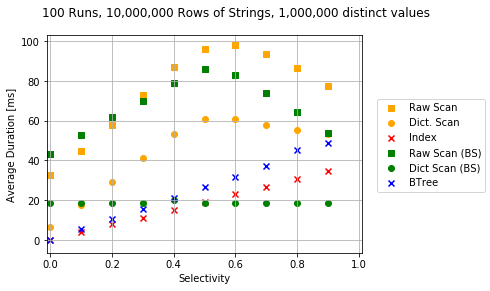

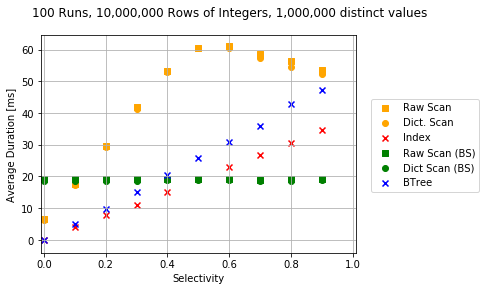

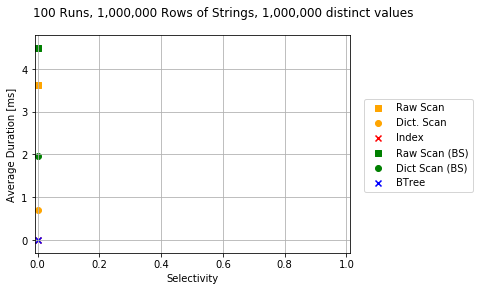

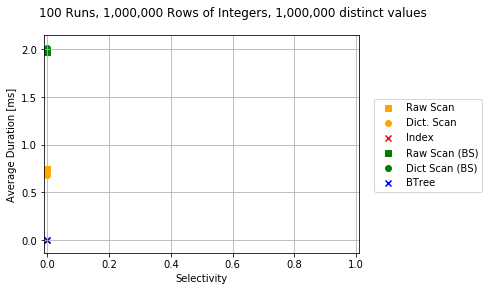

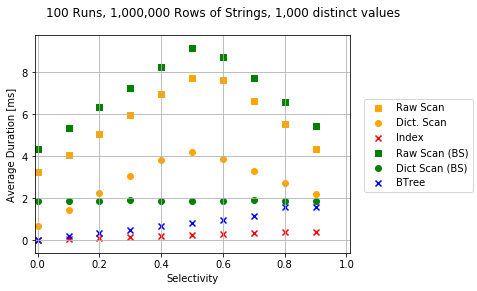

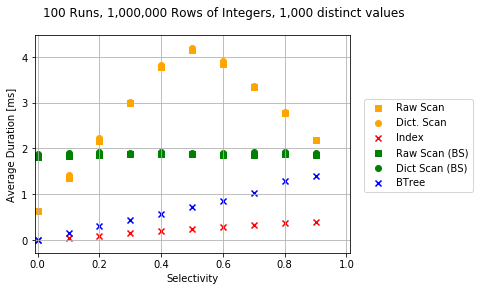

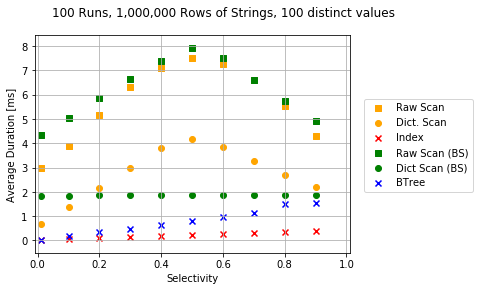

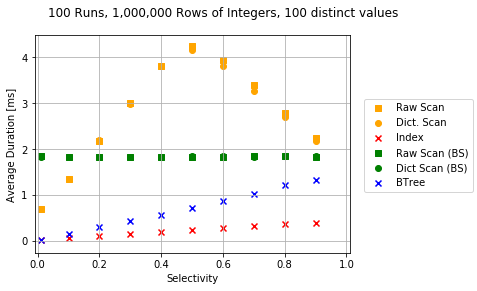

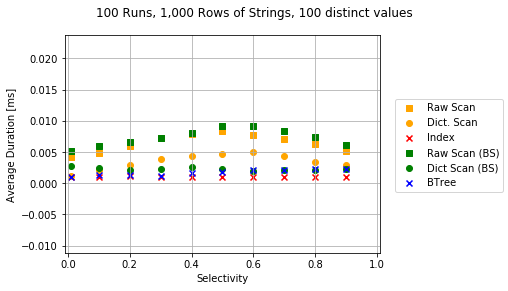

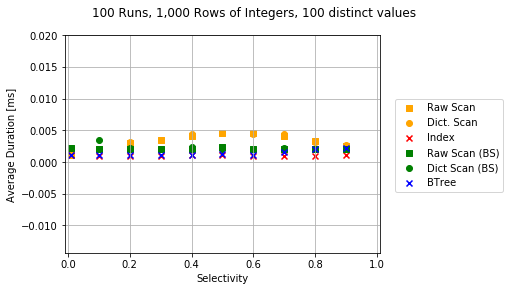

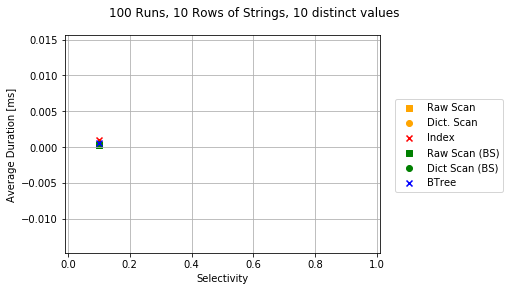

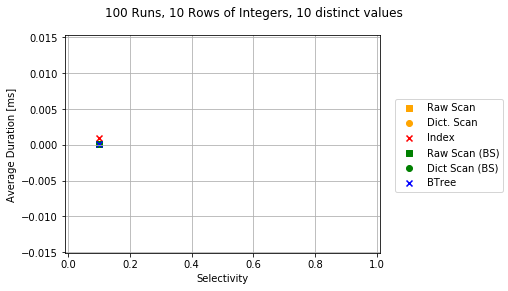

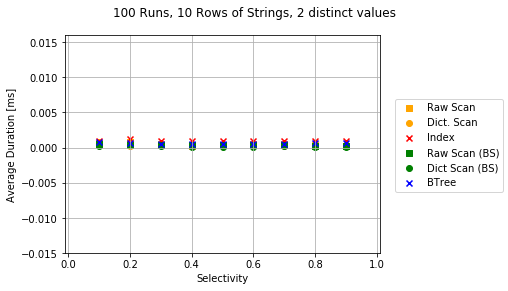

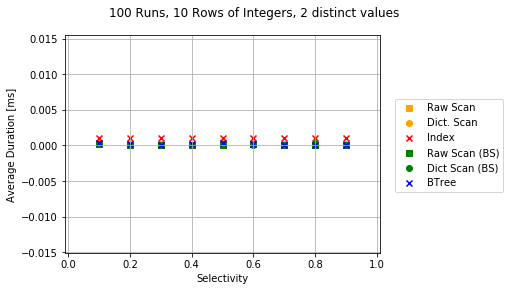

In [7]:
plots = []

axes = {
    'x': 'Selectivity',
    'y': 'AvgDuration',
    'x_label': 'Selectivity', 
    'y_label': 'Average Duration [ms]', 
}

plots.append(plot_df(get_df('./10000000_string.csv'), 'Strings', 1000000))
plots.append(plot_df(get_df('./10000000_int.csv'), 'Integers', 1000000))

files = [ './1000000-1.csv', './1000000-2.csv', './1000000-3.csv', './1000.csv', './10-1.csv', './10-2.csv' ]
distinct_values = [1000000, 1000, 100, 100, 10, 2]
for i in range(len(files)):
    df = get_df(files[i])
    df_int = df[df.column_type == TYPE_INT] 
    df_string = df[df.column_type == TYPE_STRING]
    plots.append(plot_df(df_string, 'Strings', distinct_values[i]))
    plots.append(plot_df(df_int, 'Integers', distinct_values[i]))

### Save plots if requested

In [5]:
if save_plots: 
    with PdfPages("plots week 7.pdf") as pdf:
        for plot in plots:
            pdf.savefig(plot)